In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from package_LAB import PID_RT,LeadLag_RT,IMC_tuning

In [3]:
#SOPDT PV
Kp = 0.46575892823243076
T1p = 132.04151002516983
T2p = 7.647730018039972
thetap = 0.0004910330468864688

#SOPDT DV
Kd = 0.36816132905697
T1d = 128.19758463380253
T2d = 26.094509776696448
thetad = 2.000174864808916

In [12]:
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 75
SPPath = {0:50, 5:50, 50:50, 80:50, TSim: 50}
MVPath = {0:1, 100:0, TSim:1}
#MVPath = {0:1, 100:0, TSim:1}

gamma = 0.6 
Kc,Ti,Td = IMC_tuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')

alpha = 1
MVMin = 0
MVMax = 100

In [13]:
test = 'FF'

if test == 'Man':
    # OLP + no FF
    ManPath = {0: True, TSim: True} # Path for Man
    MVManPath = {0: MV0 , Tsim : MV0} #path for MVMan
    SPPath = {0: PV0, TSim: MV0} # Path for SP, always the same in most cases
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0} # Path for DV
    ActivateFF = False
    ManFF = True

             
elif test == 'ManFF':
    # OLP + FF
    ManPath = {0: True, TSim: True} # Path for Man
    MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
    SPPath = {0: PV0, TSim: PV0} # Path for SP, always the same in most cases
    DVPath = {0: 50.0, 1000: 60,  TSim: 60.0} # Path for DV
    ActivateFF = True
    ManFF = True

          
elif test == 'FF':
    # FF + CLP
    ManPath = {0: True, 750: False,  TSim: False}# Path for Man
    MVManPath = {0: MV0, TSim: MV0}                         # Path for MVMan
    SPPath = {0: PV0, TSim: MV0}                            # Path for SP, always the same in most cases
    DVPath = {0: 50.0, 400: 60, TSim: 60.0}                 # Path for DV
    ActivateFF = True
    ManFF= False


else:
    #no FF + CLP

    ManPath = {0:True, 750: False, TSim: False} # Path for Man
    MVManPath = {0: MV0, TSim: MV0}                          # Path for MVMan
    SPPath = {0: PV0, 800:PV0-10, TSim: PV0-10}                             # Path for SP, always the same in most cases
    DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10}                  # Path for DV
    ActivateFF = False
    ManFF= False


(0.0, 500.0)

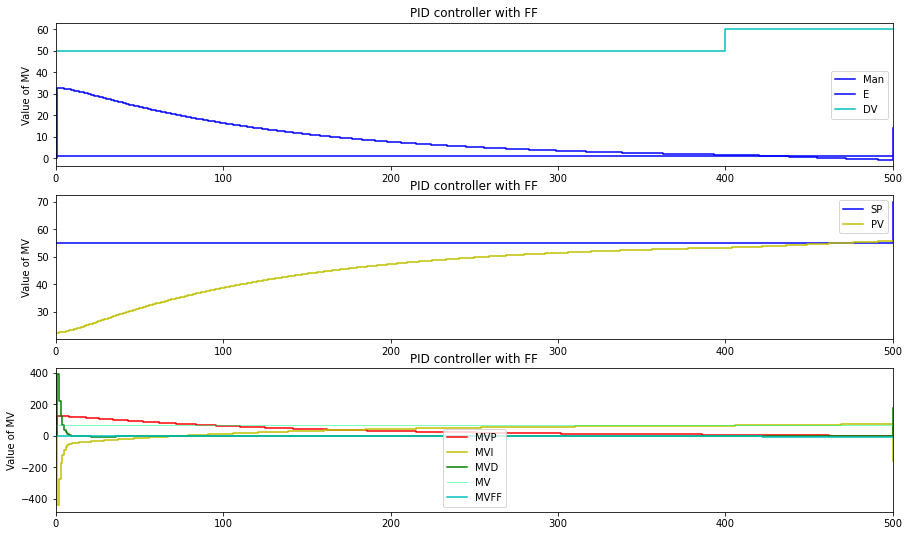

In [15]:
t = []
MVP=[]
MVI=[]
MVD=[]
DV = []
PV = []
SP = []
MV = []
E = []
MVFF = []
MVMan=[]
Man = []
MVFFDelay = []
MVFFLL = []
MVDelayp = []
MVDelayd = []
PV1p = []
PV2p = []
PV1d = []
PV2d = []


for i in range(0,N):
    t.append(i*Ts)
    
    #SP DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    #FeedForward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LeadLag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL)
    LeadLag_RT(MVFFLL,int(ActivateFF),T2p,T2d,Ts,MVFF)
    
    #Manual
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    #PID
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0,'EBD-EBD')
    
    #Input-output dynamics P(s)
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    #Disturbance dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    
    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0)
    
plt.figure(figsize = (15,9))

plt.subplot(3,1,1)
plt.step(t,Man,'b-',label='Man',where='post')
plt.step(t,E,'b-',label='E',where='post')
plt.step(t,DV,'c-',label='DV',where='post')
plt.ylabel('Value of MV')
plt.title('PID controller with FF')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(3,1,2)
plt.step(t,SP,'b-',label='SP',where='post')
plt.step(t,PV,'y-',label='PV',where='post')
plt.ylabel('Value of MV')
plt.title('PID controller with FF')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(3,1,3)
plt.step(t,MVP,'r-',label='MVP',where='post')
plt.step(t,MVI,'y-',label='MVI',where='post')
plt.step(t,MVD,'g-',label='MVD',where='post')
plt.step(t,MV,'springgreen',linewidth=0.5,label='MV',where='post')
plt.step(t,MVFF,'c-',label='MVFF',where='post')
plt.ylabel('Value of MV')
plt.title('PID controller with FF')
plt.legend(loc='best')
plt.xlim([0, TSim])